In [ ]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
!pip install konlpy

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash # 한국어 - Mecab

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
from konlpy.tag import Okt #,Mecab

## Download the data


In [ ]:
!gdown --id 1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis

In [ ]:
import pandas as pd

df = pd.read_excel('/content/1_구어체(1).xlsx')
xx = df.원문
xy= df.번역문

## Text 전처리 

korean
- okt morphs
- with stem -  결과 약간 떨어짐 (random sample이 달라서 일수도 있음)

english

- 기본 tokenizer



In [ ]:
def preprocesskr(sent):
    okt = Okt()
    sent = re.sub(r"([?.!,¿])", r" \1", sent)
    sent = re.sub(r"[^가-힣a-zA-Z!.?]+", r" ", sent)
    sent = re.sub(r"\s+", " ", sent)
    sent = okt.morphs(sent)
    return sent

In [ ]:
def preprocesseng(sent):
    sent = re.sub(r"([?.!,¿])", r" \1", sent)
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)
    sent = re.sub(r"\s+", " ", sent)
    return sent

In [ ]:
def load_preprocessed_data(kr,eng, num_samples=200000):
    encoder_input, decoder_input, decoder_target = [],[],[]

    for i, (src_line, tar_line) in enumerate(zip(kr,eng)):
        encoder_input.append(preprocesskr(src_line))
    
        tar_line = preprocesseng(tar_line)
        decoder_input.append([w for w in ('<sos> ' + tar_line).split()])
        decoder_target.append([w for w in (tar_line + ' <eos>').split()])

        if i == num_samples -1:
            break
    return encoder_input, decoder_input, decoder_target

In [ ]:
num_samples = 200000

In [ ]:
# sents_kr_in, sents_en_in, sents_en_out = load_preprocessed_data(xx,xy,num_samples)

In [ ]:
sents_kr_in, sents_en_in, sents_en_out = load_preprocessed_data(xx,xy)

In [ ]:
num_samples = 200000
sents_kr_in, sents_en_in, sents_en_out = load_preprocessed_data(xx,xy)

In [ ]:
import pickle
with open('sents_kr_in.pkl', 'rb') as f:
  sents_kr_in = pickle.load(f)

with open('sents_en_in.pkl', 'rb') as f:
  sents_en_in = pickle.load(f)

with open('sents_en_out.pkl', 'rb') as f:
  sents_en_out = pickle.load(f)


In [ ]:
print(sents_kr_in[-5:])
print('디코더의 입력 :',sents_en_in[-5:])
print('디코더의 레이블 :',sents_en_out[-5:])

[['나', '는', '먼저', '청소기', '로', '바닥', '을', '밀었어요', '.'], ['나', '는', '먼저', '팀', '과제', '를', '하고', '놀러', '갔어요', '.'], ['나', '는', '비', '같은', '멋진', '연예인', '을', '좋아해요', '.'], ['나', '는', '멋진', '자연', '경치', '를', '보고', '눈물', '을', '흘렸어', '.'], ['나', '는', '멋진', '중학교', '생활', '을', '기대합니다', '.']]
디코더의 입력 : [['<sos>', 'First', 'of', 'all', 'I', 'vacuumed', 'the', 'floor', '.'], ['<sos>', 'I', 'did', 'the', 'team', 'assignment', 'first', 'and', 'went', 'out', 'to', 'play', '.'], ['<sos>', 'I', 'like', 'cool', 'entertainer', 'like', 'Rain', '.'], ['<sos>', 'I', 'cried', 'seeing', 'the', 'amazing', 'scenery', '.'], ['<sos>', 'I', 'look', 'forward', 'to', 'a', 'great', 'middle', 'school', 'experience', '.']]
디코더의 레이블 : [['First', 'of', 'all', 'I', 'vacuumed', 'the', 'floor', '.', '<eos>'], ['I', 'did', 'the', 'team', 'assignment', 'first', 'and', 'went', 'out', 'to', 'play', '.', '<eos>'], ['I', 'like', 'cool', 'entertainer', 'like', 'Rain', '.', '<eos>'], ['I', 'cried', 'seeing', 'the', 'amazing', 'scenery

In [ ]:
len(sents_kr_in)

200000

## 25단어이상 문장 빼기

     
     English
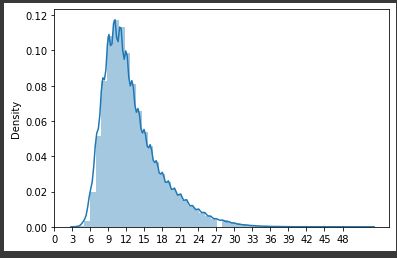
     
     
     
     Korean
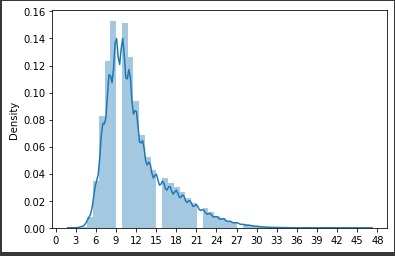


In [ ]:
sl= [len(i) for i in sents_kr_in]
drop_train= [i for i,len in enumerate(sl) if len >25]
len(drop_train)


2916

In [ ]:
xk=np.array(xx.copy())
xe=np.array(xy.copy())
xk =np.delete(xk ,drop_train, axis=0)
xe =np.delete(xe ,drop_train, axis=0)
len(xk)

197084

In [ ]:
sents_kr_in = np.delete(sents_kr_in, drop_train, axis=0)
sents_en_in = np.delete(sents_en_in, drop_train, axis=0)
sents_en_out = np.delete(sents_en_out, drop_train, axis=0)

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
len(sents_en_out)

197084

In [ ]:
drop_train1 = [i for i,t in enumerate(sents_en_in) if len(t) >25]
len(drop_train)

2916

In [ ]:
sents_kr_in = np.delete(sents_kr_in, drop_train1, axis=0)
sents_en_in = np.delete(sents_en_in, drop_train1, axis=0)
sents_en_out = np.delete(sents_en_out, drop_train1, axis=0)

In [ ]:
xk =np.delete(xk ,drop_train1, axis=0)
xe =np.delete(xe ,drop_train1, axis=0)
len(xk)

193866

In [ ]:
num_samples = len(sents_kr_in)
num_samples

193866

In [ ]:
### Tokenizer + Seq + Padding + etc

In [ ]:


tokenizer_enc = Tokenizer(filters="",oov_token="<OOV>")
tokenizer_enc.fit_on_texts(sents_kr_in)
encoder_input = tokenizer_enc.texts_to_sequences(sents_kr_in)
                    

In [ ]:
tokenizer_dec = Tokenizer(filters="", lower=False,oov_token="<OOV>")
tokenizer_dec.fit_on_texts(sents_en_in)
tokenizer_dec.fit_on_texts(sents_en_out)
decoder_input = tokenizer_dec.texts_to_sequences(sents_en_in)
decoder_target = tokenizer_dec.texts_to_sequences(sents_en_out)


In [ ]:
SRC_VOCAB_SIZE = len(tokenizer_enc.word_index) + 1
TAR_VOCAB_SIZE = len(tokenizer_dec.word_index) + 1
SRC_VOCAB_SIZE, TAR_VOCAB_SIZE

(67370, 40879)

In [ ]:
encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_target = pad_sequences(decoder_target, padding='post')

In [ ]:
encoder_input.shape, decoder_input.shape, decoder_target.shape

((193866, 25), (193866, 25), (193866, 25))

In [ ]:
MAX_ENC_LEN, MAX_DEC_LEN = encoder_input.shape[1], decoder_input.shape[1]

In [ ]:
src2idx = tokenizer_enc.word_index
idx2src = tokenizer_enc.index_word
tar2idx = tokenizer_dec.word_index
idx2tar = tokenizer_dec.index_word

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


랜덤 시퀀스 : [ 61914  82201  42651 ...  71207 172159  78043]


In [ ]:
n_of_val = int(num_samples*0.1)
encoder_input_train = encoder_input[:-n_of_val]
encoder_input_test = encoder_input[-n_of_val:]

decoder_input_train = decoder_input[:-n_of_val]
decoder_input_test = decoder_input[-n_of_val:]

decoder_target_train = decoder_target[:-n_of_val]
decoder_target_test = decoder_target[-n_of_val:]

## Train Model


In [ ]:
emb_dim= 1000
hid_dim=256
bi_hid_dim=int(hid_dim/2)

In [ ]:
# 1 Bidirectional+lstm -> 1 lstm  +attention

In [ ]:
# attention- decoder -embed,lstm 다음  dense dense

In [ ]:
from tensorflow.keras.layers import Input, Bidirectional, Concatenate
from tensorflow.keras import Model,layers

In [ ]:
enc_emb_layer = Embedding(SRC_VOCAB_SIZE, emb_dim)
encoder_bilstm = Bidirectional(LSTM(bi_hid_dim,dropout=0.2, return_sequences=True,return_state=True)) 


encoder_inputs= Input(shape=(None,))
encoder_emb= enc_emb_layer(encoder_inputs)
encoder_outputs, forward_h, forward_c, backward_h, backward_c  = encoder_bilstm(encoder_emb)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h,state_c]

In [ ]:
dec_emb_layer = Embedding(TAR_VOCAB_SIZE, hid_dim)
decoder_lstm = LSTM(hid_dim, dropout=0.2,return_sequences=True, return_state=True)
decoder_dense1 = Dense(hid_dim,activation='tanh')
decoder_dense2 = Dense(TAR_VOCAB_SIZE, activation='softmax')

decoder_inputs = Input(shape=(None,))
dec_emb = dec_emb_layer(decoder_inputs)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states)
attention = layers.Attention()([decoder_outputs,encoder_outputs])
concat = Concatenate()([decoder_outputs,attention])
dense1 = decoder_dense1(concat)
decoder_outputs = decoder_dense2(dense1)


In [ ]:
model = Model([encoder_inputs,decoder_inputs],decoder_outputs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 1000)   67370000    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, None, 256),  1156096     ['embedding[0][0]']              
                                 (None, 128),                                                 

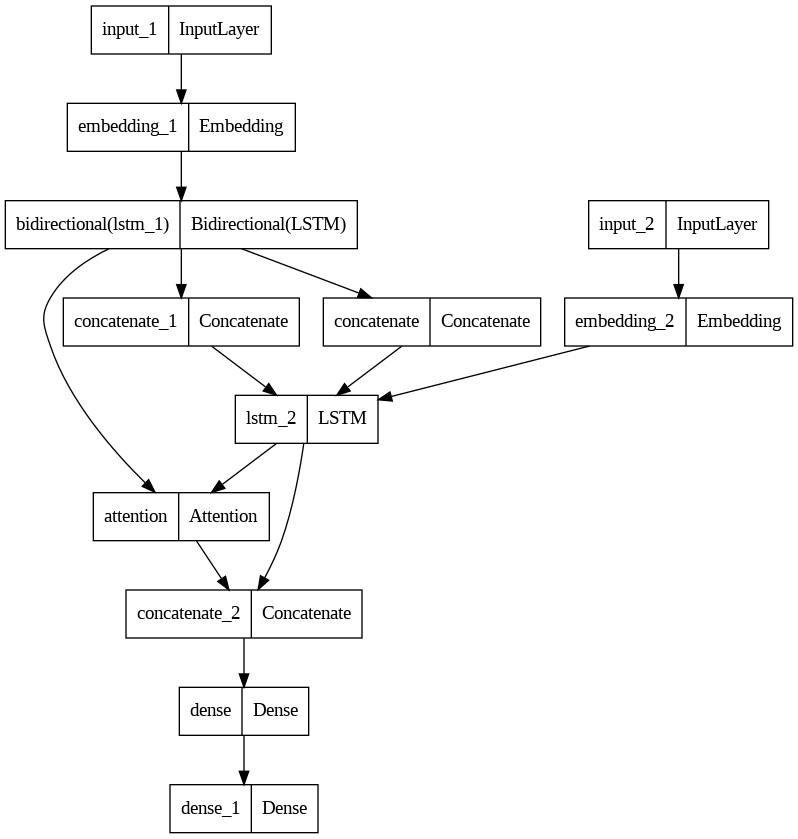

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer="sgd", loss='sparse_categorical_crossentropy', metrics=['acc'])


In [ ]:
# def scheduler(epoch, lr):
#    if epoch < 8:
#      return lr
#    else:
#      return lr * 0.5
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0)
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss', 
    save_best_only=True,
    save_weights_only=True,
    # period=5,
    save_freq='epoch'
    )

In [ ]:
history = model.fit(x = [encoder_input_train, decoder_input_train], 
          y = decoder_target_train, 
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, 
          callbacks = [earlystopping,reduce_lr,cp_callback],
          epochs = 100)

Epoch 1/100
1364/1364 [==============================] - 297s 208ms/step - loss: 2.5925 - acc: 0.6254 - val_loss: 2.1026 - val_acc: 0.6651 - lr: 0.0010
Epoch 2/100
1364/1364 [==============================] - 258s 189ms/step - loss: 1.8191 - acc: 0.6992 - val_loss: 1.6314 - val_acc: 0.7272 - lr: 0.0010
Epoch 3/100
1364/1364 [==============================] - 257s 188ms/step - loss: 1.4070 - acc: 0.7495 - val_loss: 1.4322 - val_acc: 0.7525 - lr: 0.0010
Epoch 4/100
1364/1364 [==============================] - 256s 187ms/step - loss: 1.1586 - acc: 0.7777 - val_loss: 1.3622 - val_acc: 0.7610 - lr: 0.0010
Epoch 5/100
1364/1364 [==============================] - 256s 187ms/step - loss: 0.9893 - acc: 0.7980 - val_loss: 1.3408 - val_acc: 0.7651 - lr: 0.0010
Epoch 6/100
1364/1364 [==============================] - 245s 179ms/step - loss: 0.8632 - acc: 0.8145 - val_loss: 1.3449 - val_acc: 0.7665 - lr: 0.0010
Epoch 7/100
1364/1364 [==============================] - 257s 188ms/step - loss: 0.6988 

##Inference

In [ ]:
encoder_model = Model(encoder_inputs, [encoder_states,encoder_outputs])

In [ ]:
decoder_input_h = Input(shape=(hid_dim,))
decoder_input_c = Input(shape=(hid_dim,))
decoder_encoder_outputs =Input(shape=(MAX_ENC_LEN,hid_dim,))

decoder_states_inputs = [decoder_input_h,decoder_input_c]

x= dec_emb_layer(decoder_inputs)

x, state_h2, state_c2 = decoder_lstm(x, initial_state=decoder_states_inputs)

decoder_states2 = [state_h2, state_c2]

attention = layers.Attention()([x,decoder_encoder_outputs])
concat = layers.Concatenate()([x,attention])
dense1 = decoder_dense1(concat)
x = decoder_dense2(dense1)


decoder_model = Model([decoder_inputs]+decoder_states_inputs+[decoder_encoder_outputs], [x]+decoder_states2)

In [ ]:
def translate(sentence):
    sentence = preprocesskr(sentence)
    enc_input = tokenizer_enc.texts_to_sequences([sentence])
    enc_input = pad_sequences(enc_input, maxlen=MAX_ENC_LEN, padding='post')
    states_value, output_value = encoder_model.predict(enc_input)
    target_seq = np.zeros((1,1))
    target_seq[0,0] = tar2idx['<sos>']

    stop_condition = False
    decoded_sentence = ''

    for t in range(MAX_DEC_LEN):
        output_tokens, h, c = decoder_model.predict([target_seq]+ states_value+[output_value], verbose=0)
        result_token_index = np.argmax(output_tokens[0,-1,:])
        result_word = idx2tar[result_token_index]
        decoded_sentence += ' '+result_word
        target_seq = np.zeros((1,1))
        target_seq[0,0] = result_token_index
        states_value = [h,c]
        if result_word == '<eos>':
            break

    return decoded_sentence.strip(' <eos>')


## Results

In [ ]:
!gdown 1s2oLAqeG0XSC97NEcBgaTwIHp9G_nxc7

In [ ]:
testdf = pd.read_csv('한영번역_타켓문장.csv')
testdf

In [ ]:
testsent = testdf.한글

In [ ]:
transsent=[]
for sent in testsent:
    print(sent)
    ts = translate(sent)
    transsent.append(ts)
    print(ts)

import pickle

with open(folder_path+'translated.pkl','wb') as f:
  pickle.dump(transsent,f)

정리가 필요하겠네요.
1/1 [==============================] - 0s 23ms/step
We need to make it up .
처음 만났을 때를 떠올려 보세요
1/1 [==============================] - 0s 23ms/step
Think about when we think of the first time .
구썸남 인스타에 좋아요 누름.
1/1 [==============================] - 0s 19ms/step
When you look at a calm and gentlemen it s good .
있었던 일을 차분히 생각해봐요.
1/1 [==============================] - 0s 20ms/step
Think about what happened and try .
많이 찍다보면 조금씩 실력이 늘거예요.
1/1 [==============================] - 0s 33ms/step
My little ability is getting better when I m getting a lot .
가능하면 참석하는 게 좋겠죠.
1/1 [==============================] - 0s 19ms/step
It would be better to attend if possible .
비밀연애가 말도 못하고 힘들죠.
1/1 [==============================] - 0s 20ms/step
It is difficult to say that the thing is not working .
자신을 너무 비난하지 마세요.
1/1 [==============================] - 0s 19ms/step
Don t blame yourself .
한가지만 보면 몰라요.
1/1 [==============================] - 0s 18ms/step
I don t know if you look .
당신이 덜 다치는 쪽으로 하

In [ ]:
transsent=[]
for sent in testsent:
    print(sent)
    ts = translate(sent)
    transsent.append(ts)
    print(ts)

import pickle

with open(folder_path+'translated.pkl','wb') as f:
  pickle.dump(transsent,f)

정리가 필요하겠네요.
1/1 [==============================] - 0s 26ms/step
I need it .
처음 만났을 때를 떠올려 보세요
1/1 [==============================] - 0s 18ms/step
I remember the first time I met .
구썸남 인스타에 좋아요 누름.
1/1 [==============================] - 0s 22ms/step
Please press the phone on Instagram .
있었던 일을 차분히 생각해봐요.
1/1 [==============================] - 0s 28ms/step
I will think I ll be calm down .
많이 찍다보면 조금씩 실력이 늘거예요.
1/1 [==============================] - 0s 21ms/step
A little skill is a little bit of a little bit .
가능하면 참석하는 게 좋겠죠.
1/1 [==============================] - 0s 38ms/step
I hope you can attend it .
비밀연애가 말도 못하고 힘들죠.
1/1 [==============================] - 0s 20ms/step
It s hard to say that the downy is not saying .
자신을 너무 비난하지 마세요.
1/1 [==============================] - 0s 23ms/step
Don t blame yourself .
한가지만 보면 몰라요.
1/1 [==============================] - 0s 19ms/step
I don t know if you are doing it .
당신이 덜 다치는 쪽으로 하세요.
1/1 [==============================] - 0s 25ms/step
You must b

In [ ]:
!pip install evaluate

In [ ]:
import evaluate 
from tqdm import tqdm
bleu = evaluate.load("bleu")


In [ ]:

train_idx = indices[:-n_of_val]
test_idx = indices[-n_of_val:] 

In [ ]:
n_samples = 200
ref_train, pred_train = [], []
for idx in tqdm(np.random.choice(test_idx, n_samples)):
    ref_train.append(xe[idx])
    pred_train.append(translate(xk[idx]))


In [ ]:
# 전처리- 더 짧은 padding 후
print(ref_train) 
print(pred_train)

['In the case of studying, I can show you my no.1 integrity and no.1 passion distinguished among others.', 'I want to supply the experiment equipment all over the world so that many people can use these.', 'Could you write "b" on this paper?', 'I am honored to meet you.', "I am sorry that you didn't notice anything.", 'She wanted to go to Australia but went to Guam because of her work.', 'I would like to confirm if this request was approved.', 'Would you please exchange this?', 'Can you come over and take a look at this?', 'I think your wife is meticulous.', 'This operating system is called a smartphone OS.', 'I am creating a human network in the Korean government.', 'If I use wifi, how can I pay?', "I'm going to introduce dramas out of Korean culture.", "Please refer to the attached file as I'm sending you an mail on the sow document.", "I'm always sorry that I can't be with you.", 'That tea tastes light, so it fits my taste perfectly.', 'For example, if you register the post after se

In [ ]:
# 첫 실험
print(ref_train) 
print(pred_train)

['That size suits you best.', 'Therefore, the copy of B/L is evidence that you complete the shipment of the package.', 'Why should I understand your situation?', "It's because I want to live a life in the sky.", 'It will be great if you will be able to complete before February 12th.', 'They promised never to hunt again and she turned them back again.', 'I was not successful in marriage in the Philippines.', 'The writer Ronald Dahl was born in Wales, England.', 'Today is the first day of us falling in love with each other.', 'Are Alex and Daniel going to start their food trip?', 'The cells are being well maintained.', 'There is a Korean instructor for a foreigner.', "So I'm trying to ask you a favor after thinking about this a lot.", 'What is playing at this theater this weekend?', 'The gift box contains these 6 items.', 'If you do not study English, you would have to take a test again.', 'I want to show you this movie someday.', 'Are you sure you can do that for me?', 'Did you use to h

In [ ]:
# 전처리- 긴 단어 뺀 (더 짧은 padding) 후 #### 최상의 결과

bleu.compute(predictions=pred_train, references=ref_train)

{'bleu': 0.1519392798291615,
 'precisions': [0.47470489038785835,
  0.2085635359116022,
  0.10598377281947262,
  0.050790067720090294],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0358078602620087,
 'translation_length': 2372,
 'reference_length': 2290}

In [ ]:
# 첫 실험

bleu.compute(predictions=pred_train, references=ref_train)

{'bleu': 0.13297599860818193,
 'precisions': [0.4470338983050847,
  0.17777777777777778,
  0.08877551020408163,
  0.04431818181818182],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0038281582305402,
 'translation_length': 2360,
 'reference_length': 2351}

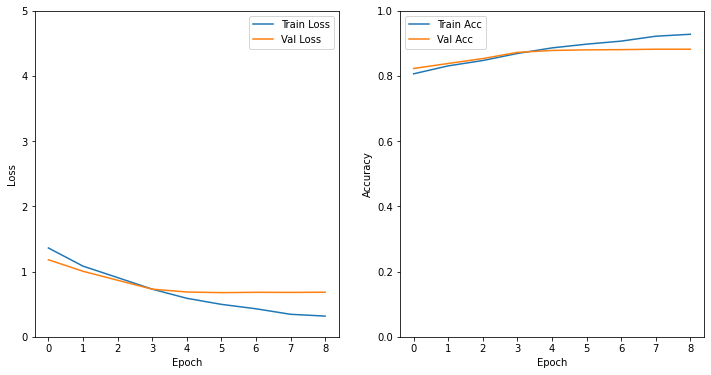

In [ ]:
#첫 실험 학습 그래프
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(12, 6))

  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'],
           label='Train Acc')
  plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val Acc')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

## 다른 모델

2 bidirectional+lstm -> 2 lstm  + attention

ref:


 Effective approaches to attention-based neural machine translation -2015 Luong
 
-4.5M sentence pairs dataset #limit vocab- top 50k, rest <unk> #filter sentences length under 50words #shuffle

-4layers- each 1000cells #1000dim_emb #lsdm dropout 0.2

-local attention- windowsize 10 #useful for long seq eg paragraphs/documents

-parameters uniformly initialized [-0.1,0.1]

-SGD (adam introduced same year 2015)  #minibatchsize128 #normalized gradient learning_rate schedule- start_lr=1, 12epochs, start halving after 8 epochs


-base+reverse+dropout+local-p attention (general) + feed input + unk replace 

In [ ]:
### Train

In [ ]:
emb_dim= 500
hid_dim=128
bi_hid_dim=int(hid_dim/2)

In [ ]:
#two stacked lstm #two states
enc_emb_layer = Embedding(SRC_VOCAB_SIZE, emb_dim)
#encoder_lstm = LSTM(hid_dim, return_state=True)
encoder_lstm1 = Bidirectional(LSTM(bi_hid_dim,dropout=0.5, return_sequences=True,return_state=True))
encoder_lstm2 = Bidirectional(LSTM(bi_hid_dim,dropout=0.5, return_sequences=True,return_state=True))


encoder_inputs= Input(shape=(None,))
encoder_emb= enc_emb_layer(encoder_inputs)
encoder_outputs1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(encoder_emb)
state_h1 = Concatenate()([forward_h1, backward_h1])
state_c1 = Concatenate()([forward_c1, backward_c1])
encoder_states1 = [state_h1,state_c1]
encoder_outputs, forward_h, forward_c, backward_h, backward_c  = encoder_lstm2(encoder_outputs1)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h,state_c]

In [ ]:
dec_emb_layer = Embedding(TAR_VOCAB_SIZE, hid_dim)
decoder_lstm1 = LSTM(hid_dim, dropout=0.5,return_sequences=True,return_state=True)
decoder_lstm2 = LSTM(hid_dim, dropout=0.5,return_sequences=True, return_state=True)
decoder_dense1 = Dense(hid_dim,activation='tanh')
decoder_dense2 = Dense(TAR_VOCAB_SIZE, activation='softmax')

decoder_inputs = Input(shape=(None,))
dec_emb = dec_emb_layer(decoder_inputs)
decoder_outputs1, _, _= decoder_lstm1(dec_emb, initial_state = encoder_states1)
decoder_outputs, _, _ = decoder_lstm2(decoder_outputs1, initial_state = encoder_states)
attention = layers.Attention()([decoder_outputs,encoder_outputs])
concat = Concatenate()([decoder_outputs,attention])
dense1 = decoder_dense1(concat)
decoder_outputs = decoder_dense2(dense1)

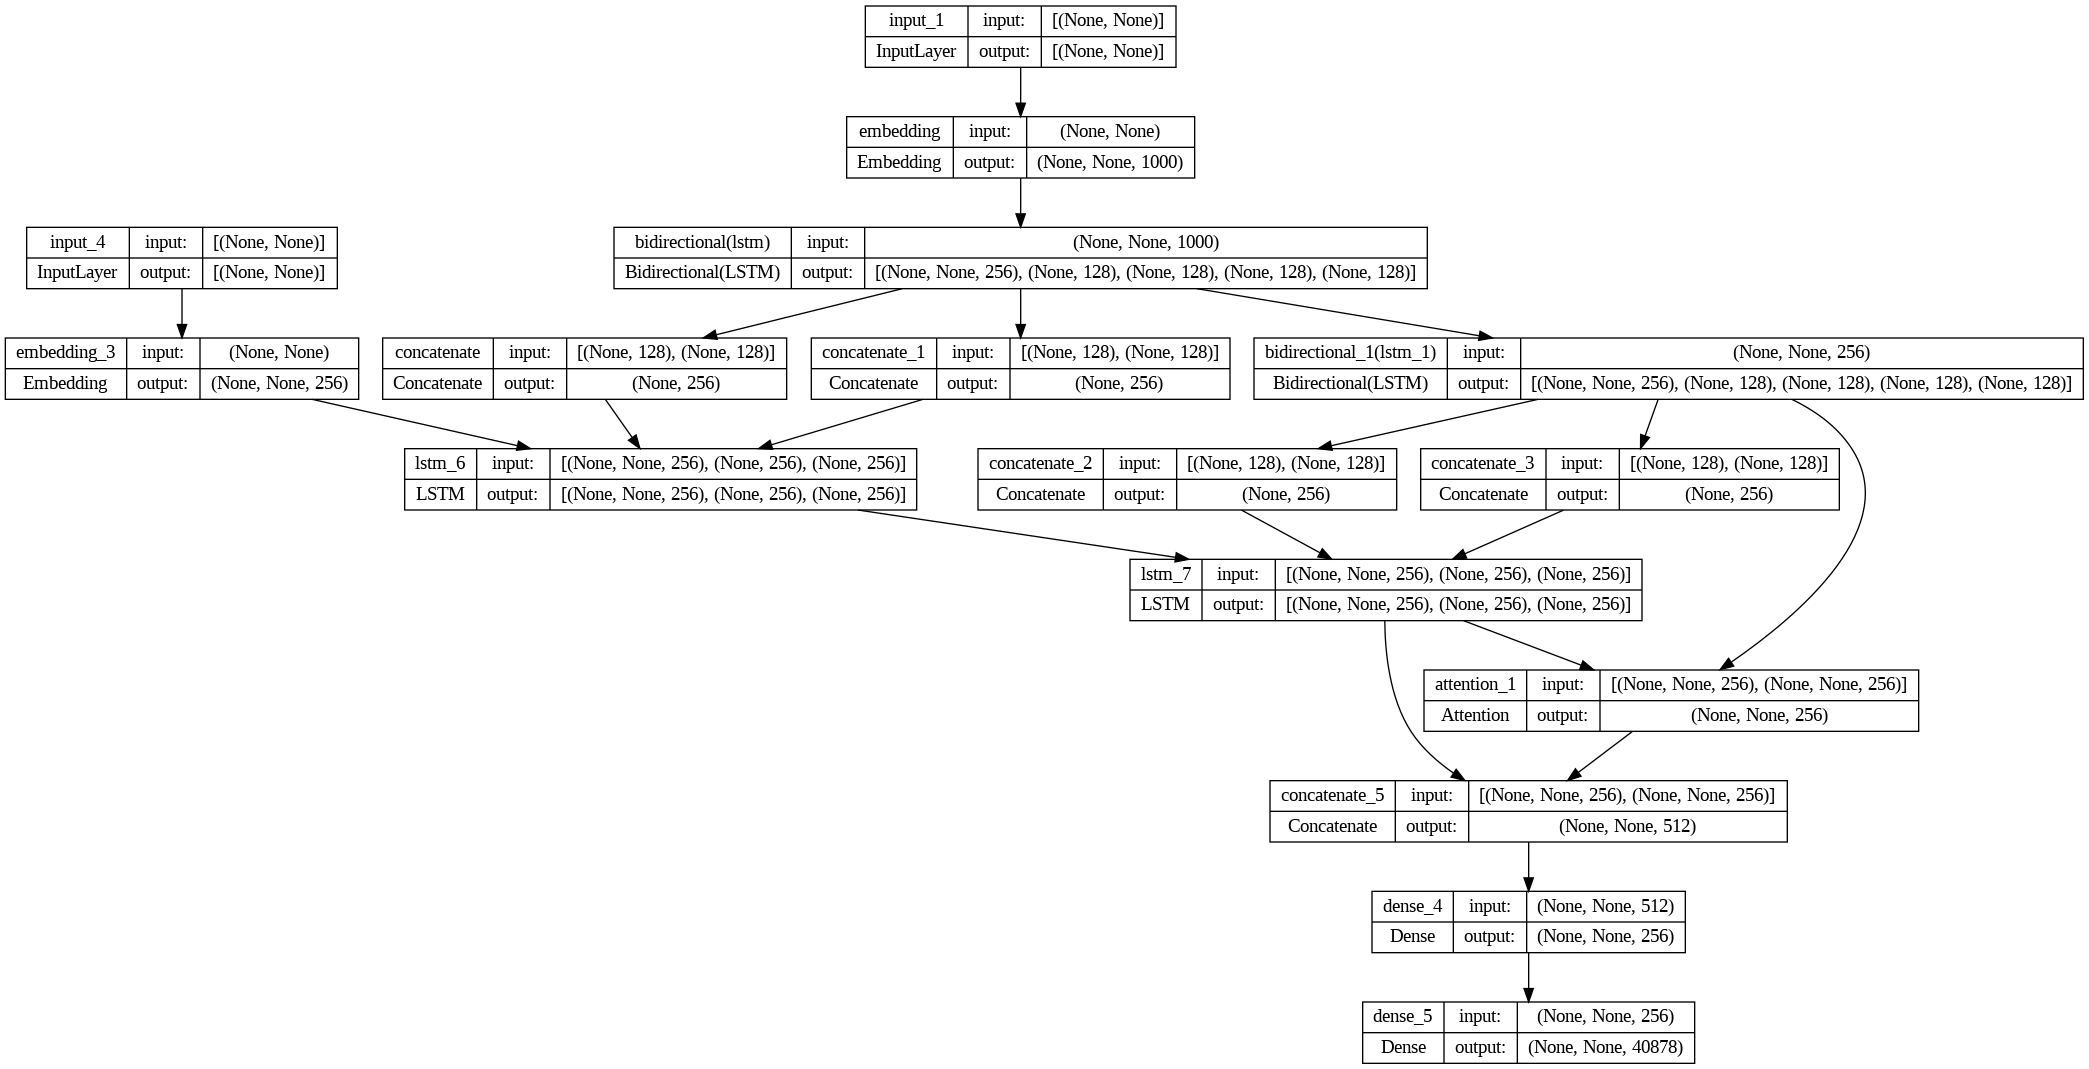

In [ ]:
#### Inference

In [ ]:
encoder_model = Model(encoder_inputs, [encoder_states1,encoder_states,encoder_outputs])

In [ ]:
decoder_input_h1 = Input(shape=(hid_dim,))
decoder_input_c1 = Input(shape=(hid_dim,))
decoder_input_h = Input(shape=(hid_dim,))
decoder_input_c = Input(shape=(hid_dim,))
decoder_encoder_outputs =Input(shape=(MAX_ENC_LEN,hid_dim,))

decoder_states_inputs1 = [decoder_input_h1,decoder_input_c1]
decoder_states_inputs = [decoder_input_h,decoder_input_c]

x= dec_emb_layer(decoder_inputs)

x, _,_= decoder_lstm1(x, initial_state=decoder_states_inputs1)
x, state_h2, state_c2 = decoder_lstm2(x, initial_state=decoder_states_inputs)

decoder_states2 = [state_h2, state_c2]

attention = layers.Attention()([x,decoder_encoder_outputs])
concat = layers.Concatenate()([x,attention])
dense1 = decoder_dense1(concat)
x = decoder_dense2(dense1)


decoder_model = Model([decoder_inputs]+decoder_states_inputs1+decoder_states_inputs+[decoder_encoder_outputs], [x]+decoder_states2)

In [ ]:
def translate(sentence):
    sentence = preprocesskr(sentence)
    enc_input = tokenizer_enc.texts_to_sequences([sentence])
    enc_input = pad_sequences(enc_input, maxlen=MAX_ENC_LEN, padding='post')
    states_value1,states_value, output_value = encoder_model.predict(enc_input)
    target_seq = np.zeros((1,1))
    target_seq[0,0] = tar2idx['<sos>']

    stop_condition = False
    decoded_sentence = ''

    for t in range(MAX_DEC_LEN):
        output_tokens, h, c = decoder_model.predict([target_seq]+ states_value1+ states_value+[output_value], verbose=0)
        result_token_index = np.argmax(output_tokens[0,-1,:])
        result_word = idx2tar[result_token_index]
        decoded_sentence += ' '+result_word
        target_seq = np.zeros((1,1))
        target_seq[0,0] = result_token_index
        states_value = [h,c]
        if result_word == '<eos>':
            break

    return decoded_sentence.strip(' <eos>')

In [ ]:
#### Result

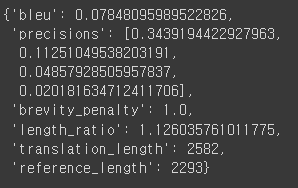